In [56]:
import geopandas as gpd
import pandas as pd
from shapely.geometry import Point

pd.set_option('display.max_columns', None)


DATA = '/Users/Marcy_Student/Desktop/marcy/DA2025_Lectures_Kevin/Mod6/Mod6_Project/Data/Motor_Vehicle_Collisions_-_Crashes_20251209.csv'

df = pd.read_csv(DATA)

# Drop bad coordinates
df = df.dropna(subset=['LATITUDE', 'LONGITUDE'])

# Convert to GeoDataFrame
gdf = gpd.GeoDataFrame(
    df,
    geometry=gpd.points_from_xy(df['LONGITUDE'], df['LATITUDE']),
    crs='EPSG:4326'
)

# Load NYC borough shapes
boros = gpd.read_file('/Users/Marcy_Student/Desktop/marcy/DA2025_Lectures_Kevin/Mod6/Mod6_Project/nybb_25d/nybb.shp')
boros = boros.to_crs('EPSG:4326')

# Spatial join: assign borough to each crash point
df = gpd.sjoin(gdf, boros[['BoroName', 'geometry']], how='left', predicate='within')

# Fill missing boroughs for modeling
df["BoroName"] = df["BoroName"].fillna("Unknown")

# Reduce datetime to hour + weekday
df["CRASH TIME"] = pd.to_datetime(df["CRASH TIME"], errors="coerce")
df["hour"] = df["CRASH TIME"].dt.hour

df["CRASH DATE"] = pd.to_datetime(df["CRASH DATE"], errors="coerce")
df["weekday"] = df["CRASH DATE"].dt.day_name()

nan_counts_per_column = df.isnull().sum()




/var/folders/tb/3_577n455q9bf55gxv6lrs4w0000gp/T/ipykernel_52252/1054169197.py:33: UserWarning:

Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.



In [51]:
print(df.groupby('BoroName')['NUMBER OF PERSONS INJURED'].sum().reset_index().sort_values(by='NUMBER OF PERSONS INJURED',ascending=False))

        BoroName  NUMBER OF PERSONS INJURED
1       Brooklyn                      64278
3         Queens                      54396
0          Bronx                      32250
2      Manhattan                      28583
4  Staten Island                       9312
5        Unknown                       2683


In [52]:
df['time_of_day'] = 'Night'  # default
# 1AM - 5AM
df.loc[df['hour'] < 6, 'time_of_day'] = 'Midnight'
# 6AM - 11AM
df.loc[(df['hour'] >= 6) & (df['hour'] < 12), 'time_of_day'] = 'Morning'
# 12PM - 6pm
df.loc[(df['hour'] >= 12) & (df['hour'] < 18), 'time_of_day'] = 'Afternoon'

df['time_of_day']

print(df.groupby('time_of_day')['NUMBER OF PERSONS INJURED'].sum().reset_index().sort_values(by='NUMBER OF PERSONS INJURED',ascending=False))


  time_of_day  NUMBER OF PERSONS INJURED
0   Afternoon                      66125
3       Night                      56174
2     Morning                      42992
1    Midnight                      26211


In [53]:
print(df.groupby(['time_of_day', 'BoroName'])['NUMBER OF PERSONS INJURED'].sum().reset_index().sort_values(by='NUMBER OF PERSONS INJURED',ascending=False))

   time_of_day       BoroName  NUMBER OF PERSONS INJURED
1    Afternoon       Brooklyn                      22629
19       Night       Brooklyn                      19270
3    Afternoon         Queens                      18223
21       Night         Queens                      15532
13     Morning       Brooklyn                      13949
15     Morning         Queens                      13084
0    Afternoon          Bronx                      10785
18       Night          Bronx                       9822
2    Afternoon      Manhattan                       9787
7     Midnight       Brooklyn                       8430
20       Night      Manhattan                       8394
9     Midnight         Queens                       7557
12     Morning          Bronx                       6997
14     Morning      Manhattan                       6008
6     Midnight          Bronx                       4646
8     Midnight      Manhattan                       4394
4    Afternoon  Staten Island  

In [54]:
# Create a scatter plot
import plotly.express as px
fig = px.scatter(
    df,
    x='hour',
    y='NUMBER OF PERSONS INJURED',
    title="Number of Persons Injured by Hour of Day",
)
fig.update_layout(xaxis_title="Hour of Day (0–23)")
fig.show()

In [55]:
# Define Features 
features = ["BOROUGH", "hour", "weekday"]
# Keep only rows with required fields
df = df.dropna(subset=features)
df

,CRASH DATE,CRASH TIME,BOROUGH,ZIP CODE,LATITUDE,LONGITUDE,LOCATION,ON STREET NAME,CROSS STREET NAME,OFF STREET NAME,NUMBER OF PERSONS INJURED,NUMBER OF PERSONS KILLED,NUMBER OF PEDESTRIANS INJURED,NUMBER OF PEDESTRIANS KILLED,NUMBER OF CYCLIST INJURED,NUMBER OF CYCLIST KILLED,NUMBER OF MOTORIST INJURED,NUMBER OF MOTORIST KILLED,CONTRIBUTING FACTOR VEHICLE 1,CONTRIBUTING FACTOR VEHICLE 2,CONTRIBUTING FACTOR VEHICLE 3,CONTRIBUTING FACTOR VEHICLE 4,CONTRIBUTING FACTOR VEHICLE 5,COLLISION_ID,VEHICLE TYPE CODE 1,VEHICLE TYPE CODE 2,VEHICLE TYPE CODE 3,VEHICLE TYPE CODE 4,VEHICLE TYPE CODE 5,geometry,index_right,BoroName,hour,weekday,time_of_day
1,2022-01-02,2025-12-10 12:50:00,QUEENS,11373.0,40.735065,-73.881840,"(40.735065, -73.88184)",GRAND AVENUE,VANKLEECK STREET,NaN,0,0,0,0,0,0,0,0,Unspecified,Unspecified,NaN,NaN,NaN,4492016,Sedan,Bike,NaN,NaN,NaN,POINT (-73.88184 40.73506),2.0,Queens,12,Sunday,Afternoon
3,2022-01-02,2025-12-10 08:44:00,BRONX,10460.0,40.842224,-73.887760,"(40.842224, -73.88776)",NaN,NaN,1902 MARMION AVENUE,0,0,0,0,0,0,0,0,Driver Inexperience,Unspecified,NaN,NaN,NaN,4491839,Sedan,Station Wagon/Sport Utility Vehicle,NaN,NaN,NaN,POINT (-73.88776 40.84222),1.0,Bronx,8,Sunday,Morning
7,2022-01-02,2025-12-10 08:40:00,BRONX,10460.0,40.842117,-73.887860,"(40.842117, -73.88786)",MARMION AVENUE,FAIRMOUNT PLACE,NaN,0,0,0,0,0,0,0,0,Driver Inattention/Distraction,Unspecified,NaN,NaN,NaN,4491595,Station Wagon/Sport Utility Vehicle,NaN,NaN,NaN,NaN,POINT (-73.88786 40.84212),1.0,Bronx,8,Sunday,Morning
9,2022-01-02,2025-12-10 16:00:00,QUEENS,11421.0,40.695827,-73.855385,"(40.695827, -73.855385)",85 ROAD,90 STREET,NaN,0,0,0,0,0,0,0,0,Backing Unsafely,Unspecified,NaN,NaN,NaN,4491510,Sedan,NaN,NaN,NaN,NaN,POINT (-73.85538 40.69583),2.0,Queens,16,Sunday,Afternoon
10,2022-01-02,2025-12-10 15:05:00,STATEN ISLAND,10305.0,40.590750,-74.088370,"(40.59075, -74.08837)",HYLAN BOULEVARD,BURGHER AVENUE,NaN,2,0,0,0,0,0,2,0,Failure to Yield Right-of-Way,Traffic Control Disregarded,NaN,NaN,NaN,4491548,Sedan,Station Wagon/Sport Utility Vehicle,NaN,NaN,NaN,POINT (-74.08837 40.59075),0.0,Staten Island,15,Sunday,Afternoon
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
370554,2025-12-05,2025-12-10 09:01:00,QUEENS,11377.0,40.752064,-73.900870,"(40.752064, -73.90087)",61 ST,34 AVE,NaN,1,0,1,0,0,0,0,0,Unspecified,NaN,NaN,NaN,NaN,4862309,Sedan,NaN,NaN,NaN,NaN,POINT (-73.90087 40.75206),2.0,Queens,9,Friday,Morning
370555,2025-12-05,2025-12-10 08:20:00,BROOKLYN,11221.0,40.687120,-73.920975,"(40.68712, -73.920975)",NaN,NaN,44 HOWARD AVE,0,0,0,0,0,0,0,0,Driver Inattention/Distraction,Unspecified,NaN,NaN,NaN,4862459,Station Wagon/Sport Utility Vehicle,Sedan,NaN,NaN,NaN,POINT (-73.92098 40.68712),4.0,Brooklyn,8,Friday,Morning
370557,2025-12-05,2025-12-10 12:24:00,BROOKLYN,11221.0,40.688790,-73.916900,"(40.68879, -73.9169)",BUSHWICK AVE,CORNELIA ST,NaN,3,0,0,0,0,0,3,0,Fatigued/Drowsy,NaN,NaN,NaN,NaN,4862592,Sedan,NaN,NaN,NaN,NaN,POINT (-73.9169 40.68879),4.0,Brooklyn,12,Friday,Afternoon
370558,2025-12-05,2025-12-10 13:47:00,BRONX,10475.0,40.868770,-73.831730,"(40.86877, -73.83173)",BARTOW AVE,BAYCHESTER AVE,NaN,2,0,0,0,0,0,2,0,Driver Inattention/Distraction,Unspecified,NaN,NaN,NaN,4862768,Bus,Station Wagon/Sport Utility Vehicle,NaN,NaN,NaN,POINT (-73.83173 40.86877),1.0,Bronx,13,Friday,Afternoon


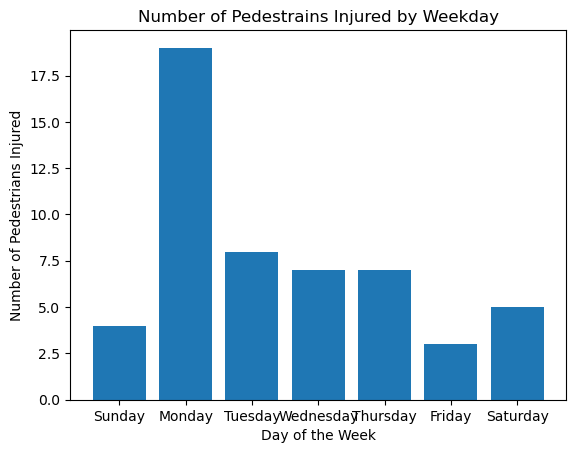

In [58]:
import matplotlib.pyplot as plt

# Create the bar plot
plt.bar(df['weekday'], df['NUMBER OF PEDESTRIANS INJURED'])

# Add labels and title (optional but recommended)
plt.xlabel('Day of the Week')
plt.ylabel('Number of Pedestrians Injured')
plt.title('Number of Pedestrains Injured by Weekday')

# Display the plot
plt.show()